<a href="https://colab.research.google.com/github/ehsan-lari/miniFood101/blob/main/minifood101_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, RandomHorizontalFlip, Compose, Resize
import matplotlib.pyplot as plt

### 1. Get Data

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if ~image_path.is_dir():
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    zip_ref.extractall(image_path)

### 2. Data preparation

In [ ]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.


In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

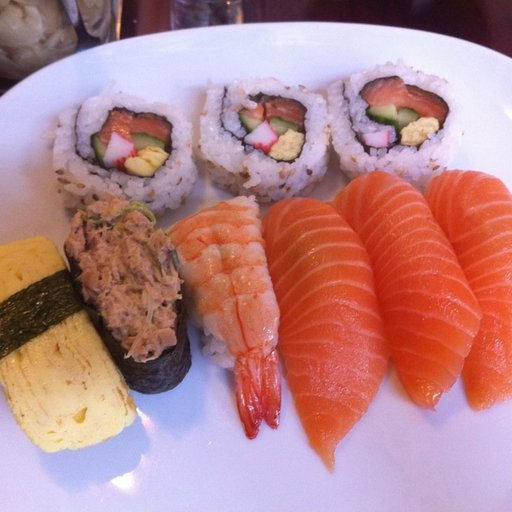

In [ ]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

img

# def view_random_image(target_dir, target_class):
#     target_folder = target_dir / target_class
#     images = os.listdir(target_folder)

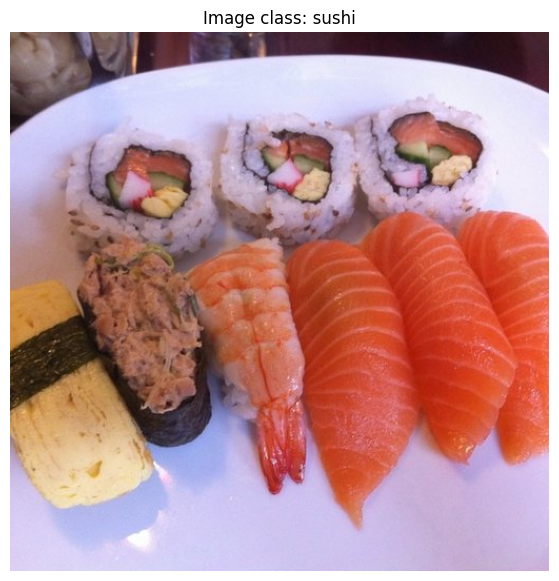

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

img_array = np.asarray(img)
plt.figure(figsize=(10, 7))
plt.axis('off')
plt.title(f"Image class: {image_class}")
plt.imshow(img_array)
plt.show()

### 3. Tranform with `torchvision.transforms()`

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [ ]:
data_transform(img).shape

torch.Size([3, 64, 64])

### 4. Use `ImageFolder`

In [ ]:
from torchvision.datasets import ImageFolder

train_data = ImageFolder(root=train_dir,
                         transform=data_transform,
                         target_transform=None)
test_data = ImageFolder(root=test_dir,
                        transform=data_transform,
                        target_transform=None)

In [ ]:
class_names = train_data.classes
class_dict = train_data.class_to_idx

### 5. Using `DataLoader` to make train and test datasets

In [ ]:
train_data_loader = DataLoader(dataset=train_data,
                               batch_size=1,
                               shuffle=True)
test_data_loader = DataLoader(dataset=test_data,
                              batch_size=1,
                              shuffle=False)

### 6. Model 0 (TinVGG)

In [ ]:
from torch import nn
from torch.nn import Sequential, Conv2d, ReLU, MaxPool2d, Flatten, Linear

In [ ]:
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
      # x = self.conv_block_1(x)
      # x = self.conv_block_2(x)
      # x = self.classifier(x)
      # return x
      return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [ ]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names))

In [ ]:
!pip -q install torchinfo

import torchinfo

from torchinfo import summary

summary(model_0, input_size=[1, 3, 64, 64])

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):

    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():

      for batch, (X, y) in enumerate(dataloader):
        y_test = model(X)
        loss = loss_fn(y_test, y)
        test_loss += loss.item()

        y_test_class = torch.argmax(torch.softmax(y_test, dim=1), dim=1)
        test_acc += (y_test_class == y).sum().item()/len(y_test)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_data_loader,
          test_data_loader,
          optimizer,
          loss_fn = nn.CrossEntropyLoss(),
          epochs: int = 5):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_data_loader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_data_loader,
                                    loss_fn=loss_fn)
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [ ]:
torch.manual_seed(42)

NUM_EPOCHS = 10

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names))

optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)
loss_fn = nn.CrossEntropyLoss()

from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model=model_0,
                         train_data_loader=train_data_loader,
                         test_data_loader=test_data_loader,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0970 | Train acc: 0.3822 | Test loss: 1.0696 | Test acc: 0.3600
Epoch: 1 | Train loss: 0.9849 | Train acc: 0.5200 | Test loss: 0.9868 | Test acc: 0.4667
Epoch: 2 | Train loss: 0.8860 | Train acc: 0.6000 | Test loss: 1.0514 | Test acc: 0.5200
Epoch: 3 | Train loss: 0.8895 | Train acc: 0.5911 | Test loss: 1.1254 | Test acc: 0.4533
Epoch: 4 | Train loss: 0.8906 | Train acc: 0.5644 | Test loss: 1.0093 | Test acc: 0.4800
Epoch: 5 | Train loss: 0.8424 | Train acc: 0.6356 | Test loss: 0.9844 | Test acc: 0.4800
Epoch: 6 | Train loss: 0.8039 | Train acc: 0.6489 | Test loss: 1.1296 | Test acc: 0.5200
Epoch: 7 | Train loss: 0.7845 | Train acc: 0.6756 | Test loss: 1.0779 | Test acc: 0.4800
Epoch: 8 | Train loss: 0.7316 | Train acc: 0.7156 | Test loss: 1.0918 | Test acc: 0.5467
Epoch: 9 | Train loss: 0.7198 | Train acc: 0.6800 | Test loss: 1.1426 | Test acc: 0.4933
Total training time: 32.379 seconds


In [ ]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
from typing import List
from typing import Dict
import matplotlib.pyplot as plt

def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results['train_loss']
  test_loss = results['test_loss']
  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

In [ ]:
plot_loss_curves(model_0_results)

In [ ]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_0_df